In [153]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [155]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
experiment_sub_dir = "2025Jun04-025014_configs"

exp_path = os.path.join(os.path.abspath("."), "results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.betas',
       'sub_exp_cfg_estimator.args_.lin_hidden_size', 'sub_experiment_path',
       'seed', 'experiment_name'],
      dtype='object')

In [156]:
df

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.betas,sub_exp_cfg_estimator.args_.lin_hidden_size,sub_experiment_path,seed,experiment_name
0,training,200000,0.971500,-7.298370,-1.978874,-4.965920,-5.003247,7.254973e-01,-6.819196,-1.912281,...,1.514570e+00,8.196434e-01,48749.0,192.0,0 days 00:07:03.797767,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
1,training,400000,0.942269,-7.681206,-2.414205,-4.956569,-4.980624,7.222659e-01,-7.167920,-2.316321,...,-2.003204e-01,9.456692e-01,50000.0,200.0,0 days 00:07:12.401632,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
2,training,600000,0.913038,-7.426469,-2.448838,-4.883217,-4.881786,7.018207e-01,-6.948117,-2.349875,...,-7.577849e-01,1.287294e+00,50000.0,200.0,0 days 00:07:36.019463,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
3,training,800000,0.883808,-7.154097,-2.249404,-4.759823,-4.782008,6.961945e-01,-6.711021,-2.167050,...,-8.209515e-01,1.347682e+00,50000.0,200.0,0 days 00:07:32.389997,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
4,training,1000000,0.854577,-7.146131,-2.275363,-4.642110,-4.651628,6.791156e-01,-6.706306,-2.190654,...,-8.158913e-01,1.345484e+00,50000.0,200.0,0 days 00:07:30.316446,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,validation,7200000,NaN,-52.236798,-52.236798,-52.236798,-52.236798,0.000000e+00,-34.260898,-34.260898,...,2.422686e+11,6.883987e+10,NaN,NaN,0 days 00:00:00.584226,"[0.5, 0.999]",256,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0005_optim.args_.betas__0.5__0.999___estimator...
1436,validation,7400000,NaN,-51.924490,-51.924490,-51.924490,-51.924490,7.105427e-15,-34.074244,-34.074244,...,2.335869e+11,6.632298e+10,NaN,NaN,0 days 00:00:00.580887,"[0.5, 0.999]",256,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0005_optim.args_.betas__0.5__0.999___estimator...
1437,validation,7600000,NaN,-51.804415,-51.804415,-51.804415,-51.804415,0.000000e+00,-33.996175,-33.996175,...,2.264699e+11,6.215288e+10,NaN,NaN,0 days 00:00:00.574223,"[0.5, 0.999]",256,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0005_optim.args_.betas__0.5__0.999___estimator...
1438,validation,7800000,NaN,-52.005059,-52.005059,-52.005059,-52.005059,0.000000e+00,-34.112429,-34.112429,...,2.170247e+11,6.003671e+10,NaN,NaN,0 days 00:00:00.583077,"[0.5, 0.999]",256,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0005_optim.args_.betas__0.5__0.999___estimator...


In [157]:
# df[df['epoch_type'] == 'validation']
df[df['epoch_type'] == 'training']


,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.betas,sub_exp_cfg_estimator.args_.lin_hidden_size,sub_experiment_path,seed,experiment_name
0,training,200000,0.971500,-7.298370,-1.978874,-4.965920,-5.003247,0.725497,-6.819196,-1.912281,...,1.514570e+00,8.196434e-01,48749.0,192.0,0 days 00:07:03.797767,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
1,training,400000,0.942269,-7.681206,-2.414205,-4.956569,-4.980624,0.722266,-7.167920,-2.316321,...,-2.003204e-01,9.456692e-01,50000.0,200.0,0 days 00:07:12.401632,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
2,training,600000,0.913038,-7.426469,-2.448838,-4.883217,-4.881786,0.701821,-6.948117,-2.349875,...,-7.577849e-01,1.287294e+00,50000.0,200.0,0 days 00:07:36.019463,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
3,training,800000,0.883808,-7.154097,-2.249404,-4.759823,-4.782008,0.696195,-6.711021,-2.167050,...,-8.209515e-01,1.347682e+00,50000.0,200.0,0 days 00:07:32.389997,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
4,training,1000000,0.854577,-7.146131,-2.275363,-4.642110,-4.651628,0.679116,-6.706306,-2.190654,...,-8.158913e-01,1.345484e+00,50000.0,200.0,0 days 00:07:30.316446,"[0.95, 0.99]",64,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.95__0.99___estimator...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,training,7200000,0.050000,-43.761138,-16.990903,-31.085683,-31.093673,4.320414,-28.554170,-12.066506,...,2.811090e+11,5.685719e+10,50000.0,200.0,0 days 00:06:36.733370,"[0.5, 0.999]",256,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0005_optim.args_.betas__0.5__0.999___estimator...
1396,training,7400000,0.050000,-43.755072,-18.298340,-31.508813,-31.597735,4.318292,-28.545260,-12.885010,...,2.700946e+11,5.485178e+10,50000.0,200.0,0 days 00:06:38.757461,"[0.5, 0.999]",256,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0005_optim.args_.betas__0.5__0.999___estimator...
1397,training,7600000,0.050000,-46.830772,-15.794946,-31.291686,-31.182793,4.390062,-30.616616,-11.325451,...,2.604111e+11,5.189017e+10,50000.0,200.0,0 days 00:06:37.171355,"[0.5, 0.999]",256,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0005_optim.args_.betas__0.5__0.999___estimator...
1398,training,7800000,0.050000,-45.834214,-14.534415,-31.381830,-31.518698,4.232663,-29.930686,-10.508628,...,2.498522e+11,4.970518e+10,50000.0,200.0,0 days 00:06:36.001751,"[0.5, 0.999]",256,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0005_optim.args_.betas__0.5__0.999___estimator...


In [158]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_optim.args_.betas                  [0.95, 0.99]
sub_exp_cfg_estimator.args_.lin_hidden_size              64
Name: 5, dtype: object
Best mean reward: -6.183011074768355


In [159]:
averaged_results

,sub_exp_cfg_optim.args_.betas,sub_exp_cfg_estimator.args_.lin_hidden_size,episode_rewards_mean,sub_experiment_path
0,"[0.5, 0.999]",128,-37.732769,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,"[0.5, 0.999]",256,-48.279381,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,"[0.5, 0.999]",64,-8.876617,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,"[0.95, 0.99]",128,-15.729071,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
4,"[0.95, 0.99]",256,-40.798531,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
5,"[0.95, 0.99]",64,-6.183011,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [160]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

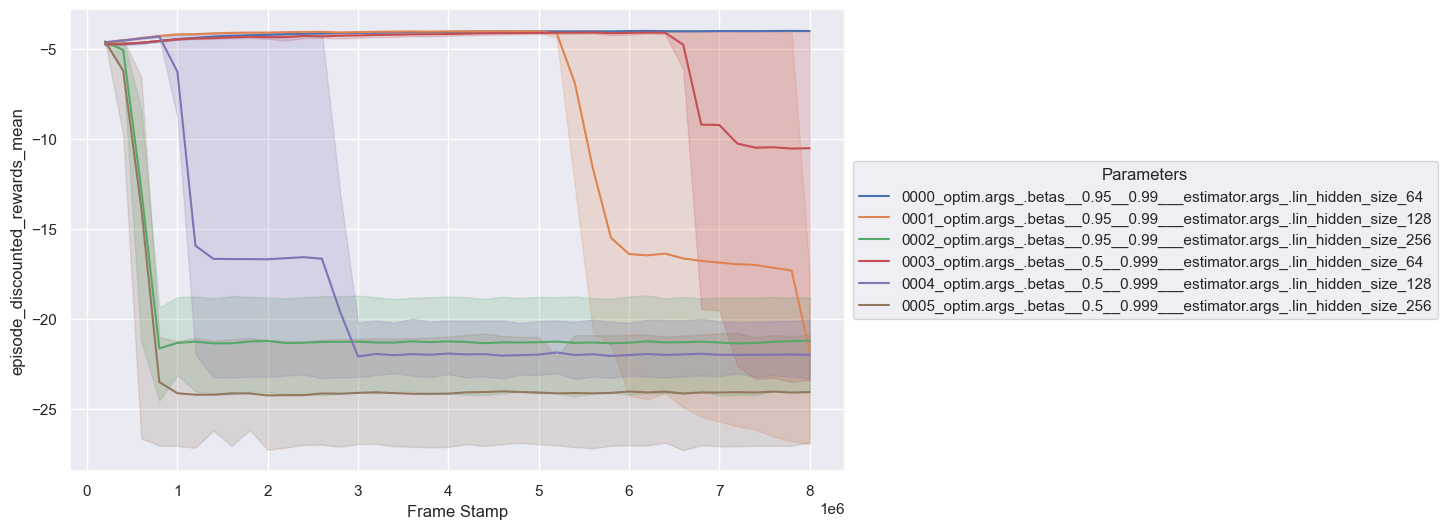

In [161]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

# validation_df = df[df['epoch_type'] == 'validation']
validation_df = df[df['epoch_type'] == 'training']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, 
             x='frame_stamp', 
             y=selected_metric, 
             hue=hue_col,
            #  units='seed', # Comment this to see mean + cf
            #  estimator=None, # Comment this to see mean + cf
             )

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [162]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.betas',
       'sub_exp_cfg_estimator.args_.lin_hidden_size', 'sub_experiment_path',
       'seed', 'experiment_name'],
      dtype='object')

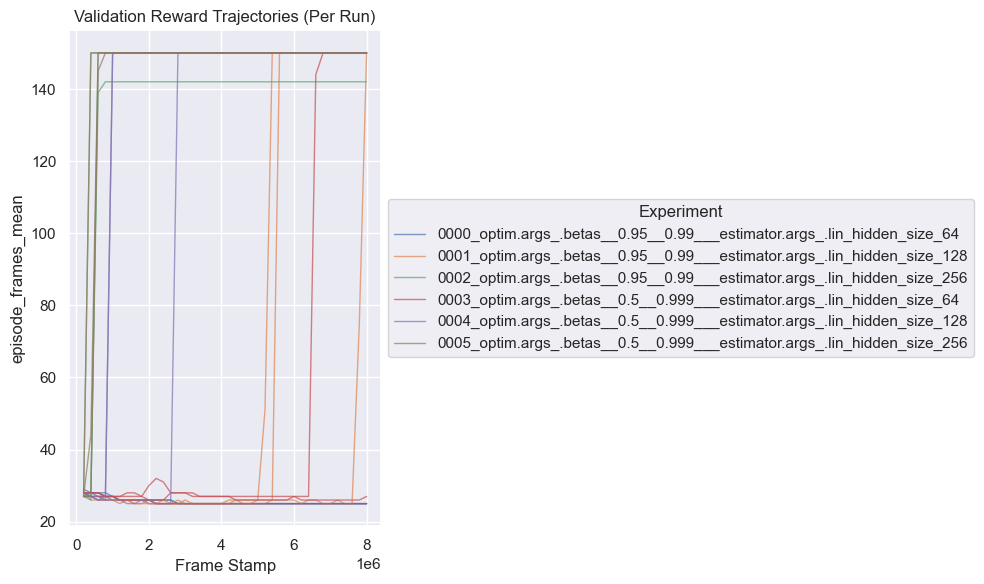

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [164]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.betas,sub_exp_cfg_estimator.args_.lin_hidden_size
79,validation,8000000,-8.189205,25.0,-7.698782,NaN,NaN,0 days 00:00:00.703838,0,0000_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",64
159,validation,8000000,-7.743422,25.0,-7.285861,NaN,NaN,0 days 00:00:00.720284,1,0000_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",64
239,validation,8000000,-7.704359,25.0,-7.249328,NaN,NaN,0 days 00:00:00.737265,2,0000_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",64
319,validation,8000000,-74.774726,150.0,-44.752620,NaN,NaN,0 days 00:00:00.786198,0,0001_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",128
399,validation,8000000,-52.263770,150.0,-34.591907,NaN,NaN,0 days 00:00:00.790335,1,0001_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",128
479,validation,8000000,-51.937994,150.0,-34.022223,NaN,NaN,0 days 00:00:00.800215,2,0001_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",128
559,validation,8000000,-61.699871,150.0,-38.765557,NaN,NaN,0 days 00:00:00.824323,0,0002_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",256
639,validation,8000000,-51.937994,150.0,-34.022223,NaN,NaN,0 days 00:00:00.876771,1,0002_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",256
719,validation,8000000,-44.983639,142.0,-30.774614,NaN,NaN,0 days 00:00:00.890038,2,0002_optim.args_.betas__0.95__0.99___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]",256
799,validation,8000000,-55.103918,150.0,-35.163232,NaN,NaN,0 days 00:00:00.740535,0,0003_optim.args_.betas__0.5__0.999___estimator...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.5, 0.999]",64


In [165]:
# agg_cols = [col for col in sub_df.columns if "sub_exp_cfg_agent_params" in col]
# aggregated_df = (
#     sub_df.groupby(agg_cols)
#     .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
#     .reset_index()
# )
# aggregated_df

In [166]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path',
       'sub_exp_cfg_optim.args_.betas',
       'sub_exp_cfg_estimator.args_.lin_hidden_size'],
      dtype='object')

In [167]:
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])



d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jun04-025014_configs\0000_optim.args_.betas__0.95__0.99___estimator.args_.lin_hidden_size_64\2


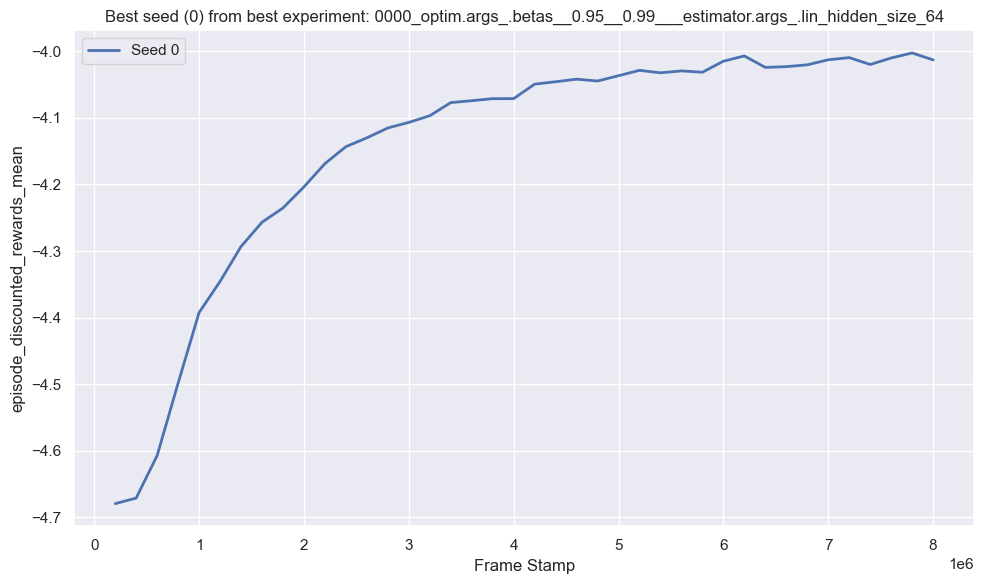

In [168]:
selected_metric = 'episode_discounted_rewards_mean'
hue_col = "experiment_name"

# Filter for training data only
training_df = df[df['epoch_type'] == 'training']
# training_df = df[df['epoch_type'] == 'validation']

# Step 1: Find best experiment
experiment_means = training_df.groupby(hue_col)[selected_metric].mean()
best_experiment = experiment_means.idxmax()

# Step 2: Filter to that experiment
best_exp_df = training_df[training_df[hue_col] == best_experiment]

# Step 3: Find best seed within best experiment
best_seed = (
    best_exp_df.groupby('seed')[selected_metric]
    .mean()
    .idxmax()
)

# Step 4: Filter to best seed
best_seed_df = best_exp_df[best_exp_df['seed'] == best_seed]

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=best_seed_df,
    x='frame_stamp',
    y=selected_metric,
    lw=2,
    label=f"Seed {best_seed}"
)

plt.title(f"Best seed ({best_seed}) from best experiment: {best_experiment}")
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.legend()
plt.tight_layout()
plt.show()

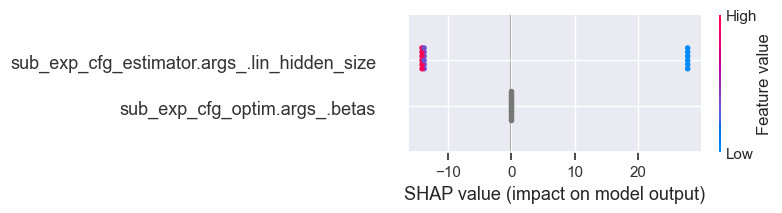

In [169]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [170]:
hyperparam_columns

['sub_exp_cfg_optim.args_.betas',
 'sub_exp_cfg_estimator.args_.lin_hidden_size']

In [171]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
